In [15]:
import time
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import lidcdataset as lidc


#constructing the dataset
img_dir = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/3D/images/"
mask_dir = "/Users/daniel/Documents/CSAI/Internship/CODE/data/LUNA16/3D/labels/"
dataset = lidc.LIDCDataset(img_dir, mask_dir)

#splitting the dataset
train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15])

#data loaders
batch_size = 1

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#test
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)


Image batch shape: torch.Size([1, 1, 64, 64, 64])
Mask batch shape: torch.Size([1, 1, 64, 64, 64])


Epoch [1/3]  Train Loss: 0.3425  Val Loss: 0.2617
Epoch [2/3]  Train Loss: 0.2617  Val Loss: 0.2617
Epoch [3/3]  Train Loss: 0.2617  Val Loss: 0.2617
Runtime 238.7989387512207


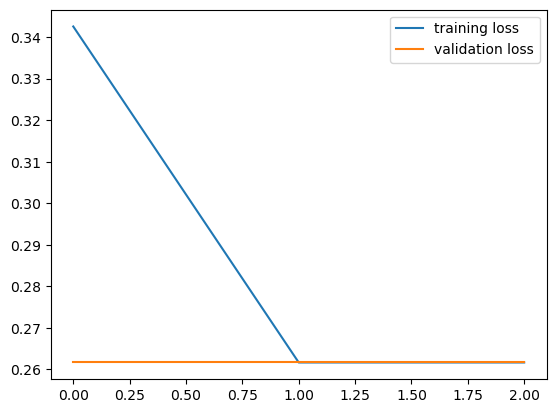

In [16]:
#training and validation loop

import unet3dmodel
import functions
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt


start = time.time()


model = unet3dmodel.Unet()

device = torch.device("cpu")
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3

train_loss_list = []
val_loss_list = []

#training loop
for epoch in range(num_epochs):

    #training
    train_loss = 0.0
    model.train()

    for images, masks in train_loader:

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        #balance the loss per batch size
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)

    train_loss_list.append(train_loss)

    #validation
    val_loss = 0.0
    model.eval()
    
    with torch.no_grad():

        for images, masks in val_loader:

            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            
            #balance the loss per batch size
            val_loss += loss.item() * images.size(0)
        
    val_loss /= len(val_loader.dataset)

    val_loss_list.append(val_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")


end = time.time()
print(f"Runtime {end - start}")

#plot training and validation loss
plt.figure()
plt.plot(train_loss_list, label='training loss')
plt.plot(val_loss_list,label='validation loss')
plt.legend()
plt.show
plt.savefig("Images/loss.png")

In [17]:
#testing loop
test_dice = 0.0
test_loss = 0.0
model.eval()

with torch.no_grad():

    for images, masks in test_loader:

        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        dice = functions.dice_coeff(outputs, masks)
        loss = criterion(outputs, masks)
        
        #balance the loss per batch size
        test_dice += dice * images.size(0)
        test_loss += loss.item() * images.size(0)
    
test_dice /= len(test_loader.dataset)    
test_loss /= len(test_loader.dataset)

print(f"Mean dice coefficient on test set: {test_dice:.4f}")
print(f"Mean loss on test set: {test_loss:.4f}")

Mean dice coefficient on test set: 0.0000
Mean loss on test set: 0.2617
